## [Machine Bias](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing): ProPublica's analysis of the COMPAS tool

This workbook restates the initial data analysis tasks, per ProPublica's [methodology description](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm) and [code](https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb)

We will do our analysis with Pandas.

In [2]:
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

### Acquiring the dataset, and understanding the data collection methodology.

Create a folder called "data" under the current folder, and download the COMPAS scores dataset.  The dataset is archived and is not expected to change.  Therefore, you can comment out this block if you already downloaded the data.

In [1]:
# Creates a folder "data" under the current folder
!mkdir -p data
# Removes any prior file if it exists
!rm -f data/compas-scores-two-years.csv*
# Fetches the most recent dataset and stores it under the folder data
!curl 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv' -o data/compas-scores-two-years.csv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2486k  100 2486k    0     0  2806k      0 --:--:-- --:--:-- --:--:-- 2803k


Inspect the file.  Read the description of the [data collection methodology](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm).  Salient points are highlighted below, with my annotations in **bold font**.  See full description from ProPublica for additional details.  

>**Goal**: We looked at more than 10,000 criminal defendants in Broward County, Florida, and compared their predicted recidivism rates with the rate that actually occurred over a two-year period.

>**COMPAS tool input (data subjects)**: When most defendants are booked in jail, they respond to a COMPAS questionnaire. Their answers are fed into the COMPAS software to generate several scores including predictions of *Risk of Recidivism* and *Risk of Violent Recidivism*

>**How COMPAS input was acquired by ProPublica**: Through a public records request, ProPublica obtained two years worth of COMPAS scores from the Broward County Sheriff’s Office in Florida. We received data for all 18,610 people who were scored in 2013 and 2014.

>**COMPAS tool output**: Each pretrial defendant received at least three COMPAS scores: “Risk of Recidivism,” “Risk of Violence” and “Risk of Failure to Appear. ... COMPAS scores for each defendant ranged from 1 to 10, with ten being the highest risk. Scores 1 to 4 were labeled by COMPAS as “Low”; 5 to 7 were labeled “Medium”; and 8 to 10 were labeled “High.”

>**Data integration (record linkage) to matching COMPAS input and output with an individual's criminal history** Starting with the database of COMPAS scores, we built a profile of each person’s criminal history, both before and after they were scored. We collected public criminal records from the Broward County Clerk’s Office website through April 1, 2016. On average, defendants in our dataset were not incarcerated for 622.87 days (sd: 329.19).

>**Data integration (record linkage) details**: We matched the criminal records to the COMPAS records using a person’s first and last names and date of birth. This is the same technique used in the Broward County COMPAS validation study conducted by researchers at Florida State University in 2010. We downloaded around 80,000 criminal records from the Broward County Clerk’s Office website.

>**What is recidivism?**: Northpointe defined recidivism as “a finger-printable arrest involving a charge and a filing for any uniform crime reporting (UCR) code.” We interpreted that to mean a criminal offense that resulted in a jail booking and took place after the crime for which the person was COMPAS scored. ... **For most of our analysis, we defined recidivism as a new arrest within two years. **

In [3]:
csv_file_vr = 'data/compas-scores-two-years.csv'
df = pd.read_csv(csv_file_vr)
df.head()


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [4]:
# projection: keep a subset of the columns in the original dataset
df1 = df[['id','sex','age', 'race','decile_score','score_text','v_decile_score','v_score_text', 
          'two_year_recid','priors_count']]

df1.head()

,id,sex,age,race,decile_score,score_text,v_decile_score,v_score_text,two_year_recid,priors_count
0,1,Male,69,Other,1,Low,1,Low,0,0
1,3,Male,34,African-American,3,Low,1,Low,1,0
2,4,Male,24,African-American,4,Low,3,Low,1,4
3,5,Male,23,African-American,8,High,6,Medium,0,1
4,6,Male,43,Other,1,Low,1,Low,0,2


### Data profiling

Understand the statistical properties of the dataset.  

Here, we inspect the basic properties of the dataset: break-down by age, gender and race.

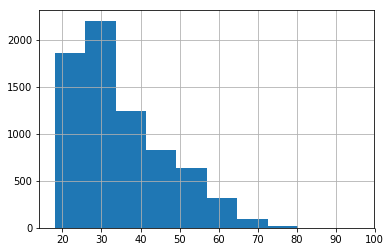

In [5]:
df1["age"].hist()

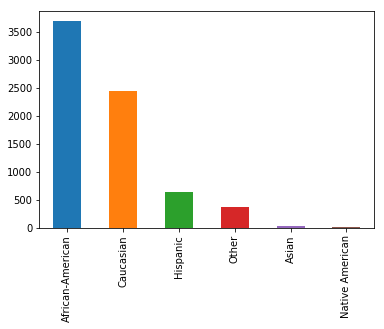

In [6]:
df1["race"].value_counts().plot(kind='bar')

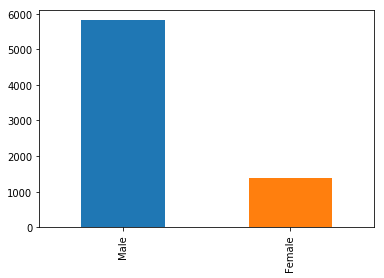

In [7]:
df1["sex"].value_counts().plot(kind='bar')

### Data cleaning

"However not all of the rows are useable for the first round of analysis.

There are a number of reasons remove rows because of missing data:

If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
We coded the recidivist flag -- is_recid -- to be -1 if we could not find a compas case at all.
In a similar vein, ordinary traffic offenses -- those with a c_charge_degree of 'O' -- will not result in Jail time are removed (only two of them).
We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility."

In [8]:
# clean the data per ProPublica's methodology
df2 = df1[(df.c_charge_degree != 'O') & (df.score_text != 'N/A') & (df.is_recid != -1)
               & (df.days_b_screening_arrest <= 30) & (df.days_b_screening_arrest >= -30)]

df2.head()


,id,sex,age,race,decile_score,score_text,v_decile_score,v_score_text,two_year_recid,priors_count
0,1,Male,69,Other,1,Low,1,Low,0,0
1,3,Male,34,African-American,3,Low,1,Low,1,0
2,4,Male,24,African-American,4,Low,3,Low,1,4
5,7,Male,44,Other,1,Low,1,Low,0,0
6,8,Male,41,Caucasian,6,Medium,2,Low,1,14


In [9]:
print('Original ', len(df))
print('Projected ', len(df1))
print ('Cleaned ', len(df2))
df2.head()

Original  7214
Projected  7214
Cleaned  6172


,id,sex,age,race,decile_score,score_text,v_decile_score,v_score_text,two_year_recid,priors_count
0,1,Male,69,Other,1,Low,1,Low,0,0
1,3,Male,34,African-American,3,Low,1,Low,1,0
2,4,Male,24,African-American,4,Low,3,Low,1,4
5,7,Male,44,Other,1,Low,1,Low,0,0
6,8,Male,41,Caucasian,6,Medium,2,Low,1,14


### Data profiling, after data cleaning 

Look at basic properties of the dataset: break-down by age, gender and race.  Compare histograms before and after data cleaning.

Observe that we are going through the lifecycle **iteratively**: profile, clean, profile again.  

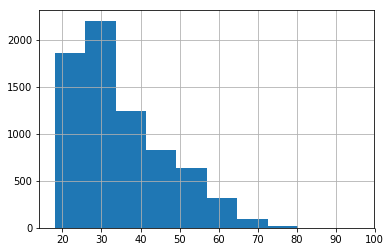

In [10]:
# visualize basic dataset statistics
df1["age"].hist()

### Data exploration

Are there differences in the distribution of risk scores by gender or race?



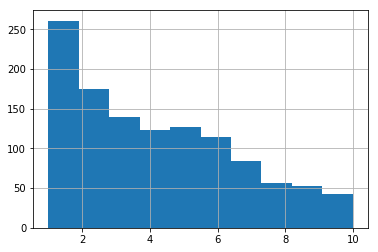

In [11]:
# compute score histograms by race and by gender 
df_f = df2[(df2.sex == 'Female')]
df_f["decile_score"].hist()

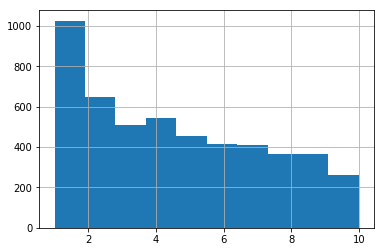

In [12]:
df_m = df2[(df2.sex == 'Male')]
df_m["decile_score"].hist()


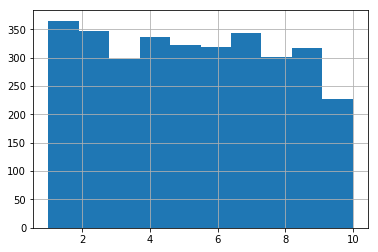

In [13]:
df_aa = df2[(df2.race == 'African-American')]
df_aa["decile_score"].hist()

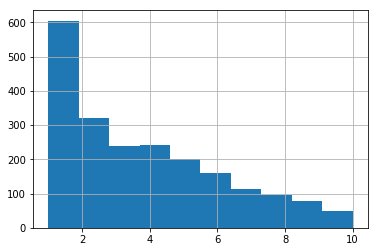

In [14]:
df_wh = df2[(df2.race == 'Caucasian')]
df_wh["decile_score"].hist()

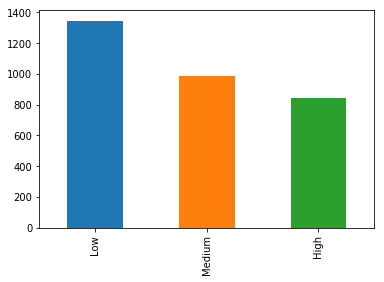

In [15]:
df_aa["score_text"].value_counts().plot(kind='bar')

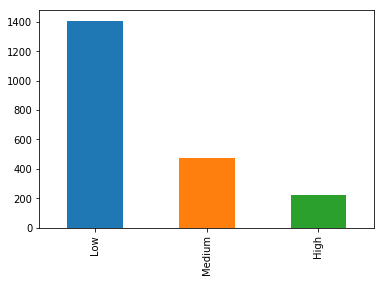

In [16]:
df_wh["score_text"].value_counts().plot(kind='bar')

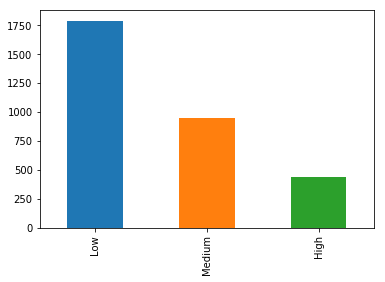

In [17]:
df_aa["v_score_text"].value_counts().plot(kind='bar')

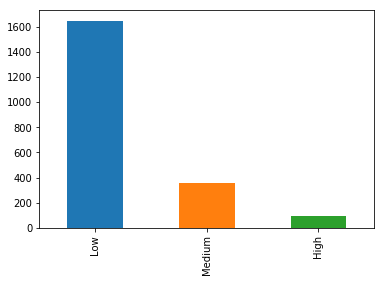

In [18]:
df_wh["v_score_text"].value_counts().plot(kind='bar')

### Data analysis

See [ProPublica article](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm) for details.  When evaluating performance of the prediction instrument, we consider **accuracy** and **parity** (or **balance**).

- **High false-positives rates** Of those deemed likely to re-offend, in any crime category, only 61 percent were arrested for any subsequent crimes within two years.  Only 20 percent of people predicted to commit violent crimes actually went on to do so.

- **Racial skew in scores** Scores for white defendants were skewed toward lower-risk categories. Scores for black defendants were not -- a symptom  of a potential problem.

- **Racial skew in false-positive rates** 44.9% of African Americans are labeled high-risk but don't reoffend, compared to 23.5% of Caucasians.

- **Racial skew in false-negative rates** 47.7% of Caucasians are labeled low-risk but do re-offend, compared to 28% of African Americans.

### Be a data skeptic!

What do we mean when we say that data is biased?  Societal bias?  Measurement bias?

Consider the COMPAS questionaire.  Race is not one of the questions.  Then why are we seeing a difference in recidivism scores across the populations?

### Be a technology skeptic!

African Americans have higher recidivism rates.  [Recent results](https://arxiv.org/abs/1703.00056) show that when recidivism rates are different across sub-populations, then we cannot simultaneously equalize false-positive rates and false-negative rates!  

This is **not** a technical issue: it is not our definition that's flawed!  Our society exhibits structural bias, which processes like those studies here reinforce.
